nbr of nodes: 9877
nbr of edges: 25998
nbr of connected components: 429
largest connected component subgraph ()= giant connected component): Graph with 8638 nodes and 24827 edges
proportion of nodes from the giant with respect to the whole graph: 87.45570517363572%
proportion of edges from the giant with respect to the whole graph: 95.49580736979767%
min degree of nodes: 1
max degree of nodes: 65
median degree of nodes: 3.0
mean degree of nodes: 5.264351523742027
global clustering coefficent of the graph (fraction of all possible triangles present in G): 0.2839996525875546


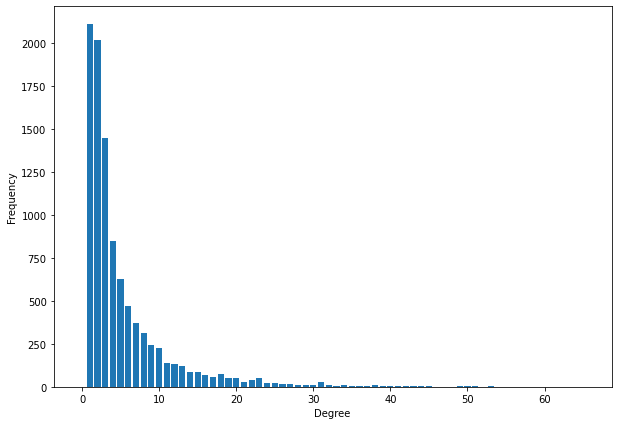

In [6]:
"""
Graph Mining - ALTEGRAD - Dec 2021
"""

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


############## Task 1

G = nx.read_edgelist("CA-HepTh.txt", delimiter = "\t")
print(f"nbr of nodes: {len(G.nodes)}")
print(f"nbr of edges: {len(G.edges)}")

############## Task 2

#### generate graph ####

print(f"nbr of connected components: {nx.number_connected_components(G)}")
giant = G.subgraph(max(nx.connected_components(G), key=len))
print(f"largest connected component subgraph ()= giant connected component): {giant}")
print(f"proportion of nodes from the giant with respect to the whole graph: {len(giant.nodes)/len(G.nodes)*100}%")
print(f"proportion of edges from the giant with respect to the whole graph: {len(giant.edges)/len(G.edges)*100}%")

############## Task 3
# Degree
degree_sequence = [G.degree(node) for node in G.nodes]
degree_sequence.sort()

print(f"min degree of nodes: {degree_sequence[0]}")

print(f"max degree of nodes: {degree_sequence[-1]}")

print(f"median degree of nodes: {np.median(degree_sequence)}")

print(f"mean degree of nodes: {np.mean(degree_sequence)}")

############## Task 4

degree_frequencies = nx.degree_histogram(G)

plt.figure(figsize=(10, 7)) 
plt.bar(np.arange(len(degree_frequencies)), degree_frequencies)
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.figure(figsize=(10, 7)) 
plt.loglog(np.arange(len(degree_frequencies)), degree_frequencies,'go-') 
plt.xlabel('Degree')
plt.ylabel('Frequency')

############## Task 5

print(f"global clustering coefficent of the graph (fraction of all possible triangles present in G): {nx.transitivity(G)}")


In [7]:
from scipy.sparse.linalg import eigs
from random import randint
from sklearn.cluster import KMeans

############## Task 6

# Perform spectral clustering to partition graph G into k clusters

def spectral_clustering(G, k):

  I = np.eye(len(G.nodes))
  inv_D = np.diag( [1/G.degree(node) for node in G.nodes] )
  A = nx.adjacency_matrix(G)
  L = I - inv_D @ A
  
  eigenvalues, eigenvectors = eigs(L, which = 'SR', k = k)
    
  cls = KMeans(n_clusters=k)
  cls.fit( np.real(eigenvectors) )

  clustering={}

  for index, node in enumerate(G.nodes):
    clustering[node] = cls.labels_[index]
  
  return clustering

############## Task 7

_spectral_clustering = spectral_clustering(giant, 50)

_random_partition = {}
for node in giant.nodes:
  _random_partition[node] = np.random.randint(50)

############## Task 8

# Compute modularity value from graph G based on clustering

def modularity(G, clustering):
    
  clusters = np.unique(list(clustering.values()))
  m = len(G.edges)

  modularity = 0

  for community in clusters:
    l = len(G.subgraph([node for node in G.nodes if clustering[node]==community]).edges)
    d = sum([value for (node, value) in G.degree() if clustering[node]==community])
    modularity += l/m - (d/(2*m))**2
  
  return modularity

############## Task 9

spectral_clustering_modularity = modularity(giant, _spectral_clustering)
random_partition_modularity = modularity(giant, _random_partition)

print(f"spectral_clustering_modularity: {spectral_clustering_modularity} vs. random_partition_modularity: {random_partition_modularity}")

spectral_clustering_modularity: 0.15568684424180854 vs. random_partition_modularity: 0.0009217918580213851


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


############## Task 10

# Generate simple dataset

def create_dataset():

  Gs = list()
  y = list()

  for g in range(3,103):

    Gs.append(nx.cycle_graph(g))
    y.append(0)

    Gs.append(nx.path_graph(g))
    y.append(1)

  return Gs, y


Gs, y = create_dataset()
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)


# Compute the shortest path kernel
def shortest_path_kernel(Gs_train, Gs_test):    
    all_paths = dict()
    sp_counts_train = dict()
    
    for i,G in enumerate(Gs_train):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_train[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_train[i]:
                        sp_counts_train[i][length] += 1
                    else:
                        sp_counts_train[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)
                        
    sp_counts_test = dict()

    for i,G in enumerate(Gs_test):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_test[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_test[i]:
                        sp_counts_test[i][length] += 1
                    else:
                        sp_counts_test[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    phi_train = np.zeros((len(G_train), len(all_paths)))
    for i in range(len(G_train)):
        for length in sp_counts_train[i]:
            phi_train[i,all_paths[length]] = sp_counts_train[i][length]
    
  
    phi_test = np.zeros((len(Gs_test), len(all_paths)))
    for i in range(len(Gs_test)):
        for length in sp_counts_test[i]:
            phi_test[i,all_paths[length]] = sp_counts_test[i][length]

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test



############## Task 11

# Compute the graphlet kernel

def graphlet_kernel(Gs_train, Gs_test, n_samples=200):

    graphlets = [nx.Graph(), nx.Graph(), nx.Graph(), nx.Graph()]
    
    graphlets[0].add_nodes_from(range(3))

    graphlets[1].add_nodes_from(range(3))
    graphlets[1].add_edge(0,1)

    graphlets[2].add_nodes_from(range(3))
    graphlets[2].add_edge(0,1)
    graphlets[2].add_edge(1,2)

    graphlets[3].add_nodes_from(range(3))
    graphlets[3].add_edge(0,1)
    graphlets[3].add_edge(1,2)
    graphlets[3].add_edge(0,2)

    
    phi_train = np.zeros((len(Gs_train), 4))

    for _ in range(n_samples):

      for G in range(len(Gs_train)):

        s = np.random.choice(Gs_train[G].nodes, size = 3)
        subgraph = Gs_train[G].subgraph(s)

        for graphlet in range(len(graphlets)):

          phi_train[G, graphlet] += int(nx.algorithms.isomorphism.is_isomorphic(subgraph, graphlets[graphlet]))


    phi_test = np.zeros((len(Gs_test), 4))
    
    for _ in range(n_samples):

      for G in range(len(Gs_test)):

        s = np.random.choice(Gs_test[G].nodes, size = 3)
        subgraph = Gs_test[G].subgraph(s)

        for graphlet in range(len(graphlets)):

          phi_test[G, graphlet] += int(nx.algorithms.isomorphism.is_isomorphic(subgraph, graphlets[graphlet]))


    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test


K_train_sp, K_test_sp = shortest_path_kernel(G_train, G_test)



############## Task 12

K_train_g, K_test_g = graphlet_kernel(G_train, G_test)



############## Task 13

# Initialize SVM and train
clf_sp = SVC(kernel="precomputed")
clf_sp.fit(K_train_sp, y_train)

# Predict
y_pred_sp = clf_sp.predict(K_test_sp)
print(f"classification accuracy shortest path kernel: {accuracy_score(y_test, y_pred_sp)}\n")

# Initialize SVM and train
clf_g = SVC(kernel="precomputed")
clf_g.fit(K_train_g, y_train)

# Predict
y_pred_g = clf_g.predict(K_test_g)
print(f"classification accuracy graphlet kernel: {accuracy_score(y_test, y_pred_g)}\n")


classification accuracy shortest path kernel: 1.0

classification accuracy graphlet kernel: 0.4

